### **Customer Churn Model**

Customer churn dataset from: [Kaggle Dataset](https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset?resource=download&select=customer_churn_dataset-training-master.csv)


### **Importing Dataset and Packages**

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

path = kagglehub.dataset_download("muhammadshahidazeem/customer-churn-dataset")

## **Data Wrangling And EDA** ##

In [2]:
file_path = r"C:\Users\Luka_Butskhrikidze\.cache\kagglehub\datasets\muhammadshahidazeem\customer-churn-dataset\versions\1\customer_churn_dataset-training-master.csv"
data = pd.read_csv(file_path)

# Split the data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print(train_data.head())

        CustomerID   Age  Gender  Tenure  Usage Frequency  Support Calls  \
39267      39597.0  31.0  Female    60.0              9.0            9.0   
201478    206375.0  21.0  Female    20.0             15.0            5.0   
99810     102769.0  47.0  Female    10.0             26.0            7.0   
326974    334089.0  36.0    Male    28.0             17.0            2.0   
317912    325027.0  50.0    Male    20.0             21.0            4.0   

        Payment Delay Subscription Type Contract Length  Total Spend  \
39267            15.0          Standard       Quarterly       589.00   
201478           13.0          Standard          Annual       715.03   
99810             8.0             Basic       Quarterly       610.00   
326974            4.0          Standard       Quarterly       967.79   
317912           14.0           Premium          Annual       677.51   

        Last Interaction  Churn  
39267               25.0    1.0  
201478              14.0    1.0  
99810   

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 352666 entries, 39267 to 121958
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         352665 non-null  float64
 1   Age                352665 non-null  float64
 2   Gender             352665 non-null  object 
 3   Tenure             352665 non-null  float64
 4   Usage Frequency    352665 non-null  float64
 5   Support Calls      352665 non-null  float64
 6   Payment Delay      352665 non-null  float64
 7   Subscription Type  352665 non-null  object 
 8   Contract Length    352665 non-null  object 
 9   Total Spend        352665 non-null  float64
 10  Last Interaction   352665 non-null  float64
 11  Churn              352665 non-null  float64
dtypes: float64(9), object(3)
memory usage: 35.0+ MB


Seems like we have only one NA value

### **Cohort Analysis From Training Data**

In [7]:
cohort_data = data.groupby(pd.cut(data['Tenure'], bins=[0, 12, 24, 36, 48, 60, 100],
                                  labels=["0-12 months", "12-24 months", "24-36 months","36-48 months", "48-60 months", "60+ months"])).agg(
                                  total_customers=('CustomerID', 'count'),
                                  churned_customers=('Churn', 'sum'))

# Creating a new column with churn_rate in percentages
cohort_data['churn_rate'] = round(cohort_data['churned_customers'] / cohort_data['total_customers'] * 100, 1)
cohort_data

C:\Users\Luka_Butskhrikidze\AppData\Local\Temp\ipykernel_13792\178820014.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_data = data.groupby(pd.cut(data['Tenure'], bins=[0, 12, 24, 36, 48, 60, 100],


,total_customers,churned_customers,churn_rate
Tenure,,,
0-12 months,85129,50000.0,58.7
12-24 months,79967,50597.0,63.3
24-36 months,91473,49509.0,54.1
36-48 months,91932,49760.0,54.1
48-60 months,92331,50133.0,54.3
60+ months,0,0.0,NaN


#### The cohort analysis reveals that churn is highest in the 12-24 month range, with 63.3% of customers leaving during this period. This suggests that after the first year, many customers reevaluate their subscriptions and decide to leave. The 0-12 month cohort also experiences a high churn rate (58.7%), indicating potential challenges with onboarding, engagement, or early customer satisfaction. ####

#### However, after 24 months, the churn rate stabilizes at around 54%, implying that customers who stay beyond two years are more likely to remain loyal. Interestingly, there are no customers in the 60+ month cohort, likely due to dataset limitations. These findings suggest that retention efforts should be concentrated within the first two years, especially between 12-24 months, where churn is at its peak. ####

### **Categorical Data Encoding** ###

In [14]:
data_encoded = data.copy()

nominal_features = ['Gender', 'Subscription Type']
ordinal_features = ['Contract Length']
contract_order = ['Monthly', 'Quarterly', 'Annual']

data_encoded['Contract Length'].fillna(data_encoded['Contract Length'].mode()[0], inplace=True)

one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # Updated parameter name
encoded_nominal = one_hot_encoder.fit_transform(data_encoded[nominal_features])
encoded_nominal_df = pd.DataFrame(encoded_nominal, 
                                  columns=one_hot_encoder.get_feature_names_out(nominal_features))

encoded_nominal_df.head()

C:\Users\Luka_Butskhrikidze\AppData\Local\Temp\ipykernel_13792\3279622913.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_encoded['Contract Length'].fillna(data_encoded['Contract Length'].mode()[0], inplace=True)


,Gender_Male,Gender_nan,Subscription Type_Premium,Subscription Type_Standard,Subscription Type_nan
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0


In [15]:
ordinal_encoder = OrdinalEncoder(categories=[contract_order])
encoded_ordinal = ordinal_encoder.fit_transform(data_encoded[ordinal_features])
encoded_ordinal_df = pd.DataFrame(encoded_ordinal, columns=ordinal_features)
encoded_ordinal_df.head()


,Contract Length
0,2.0
1,0.0
2,1.0
3,0.0
4,0.0


In [16]:
data_encoded = data_encoded.drop(columns=nominal_features + ordinal_features)
data_encoded = pd.concat([data_encoded, encoded_nominal_df, encoded_ordinal_df], axis=1)
data_encoded.head()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn,Gender_Male,Gender_nan,Subscription Type_Premium,Subscription Type_Standard,Subscription Type_nan,Contract Length
0,2.0,30.0,39.0,14.0,5.0,18.0,932.0,17.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0
1,3.0,65.0,49.0,1.0,10.0,8.0,557.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,55.0,14.0,4.0,6.0,18.0,185.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,5.0,58.0,38.0,21.0,7.0,7.0,396.0,29.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,6.0,23.0,32.0,20.0,5.0,8.0,617.0,20.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


## Scaling and Getting Data ready for Models ##

In [17]:
numerical_features = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 
                      'Payment Delay', 'Total Spend', 'Last Interaction']

scaler = StandardScaler()
data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])
data_encoded

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn,Gender_Male,Gender_nan,Subscription Type_Premium,Subscription Type_Standard,Subscription Type_nan,Contract Length
0,2.0,-0.753326,0.448760,-0.210511,0.454549,0.609620,1.247427,0.293052,1.0,0.0,0.0,0.0,1.0,0.0,2.0
1,3.0,2.059646,1.028278,-1.724562,2.083100,-0.601319,-0.309865,-0.986584,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,1.255940,-1.000036,-1.375166,0.780259,0.609620,-1.854698,-1.335575,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,5.0,1.497051,0.390808,0.604748,1.105969,-0.722413,-0.978462,1.689018,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,6.0,-1.315921,0.043097,0.488282,0.454549,-0.601319,-0.060698,0.642043,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440828,449995.0,0.211121,1.318037,-0.094045,-0.848291,-1.206788,0.352005,-0.753923,0.0,1.0,0.0,1.0,0.0,0.0,2.0
440829,449996.0,-1.155179,-1.347747,-0.326976,-0.848291,0.851808,0.472436,-1.451906,0.0,0.0,0.0,1.0,0.0,0.0,2.0
440830,449997.0,-1.074809,0.216952,1.303541,-0.848291,-0.964600,1.435589,-0.637592,0.0,1.0,0.0,0.0,1.0,0.0,1.0
440831,449998.0,-0.914068,1.375989,-0.210511,-0.522581,-1.570070,-0.120706,-1.451906,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [18]:
# Reducing dataset size further by selecting a smaller random sample
data_sampled = data_encoded.sample(n=5000, random_state=42)

# Features and target variables
selected_features = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 
                     'Payment Delay', 'Total Spend', 'Last Interaction', 
                     'Gender_Male', 'Subscription Type_Premium', 
                     'Subscription Type_Standard', 'Contract Length']

X = data_sampled[selected_features]
y = data_sampled['Churn']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputing missing values with the median for numerical features
imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

# Standardizing numerical features
scaler = StandardScaler()
X_train[selected_features] = scaler.fit_transform(X_train[selected_features])
X_test[selected_features] = scaler.transform(X_test[selected_features])

# Dictionary to store model results
results = {}

## **K-Nearest Neighbors (KNN)** ##

In [19]:
# Initializing KNN score and K values
best_knn_score = 0
best_knn_k = None

for k in [3, 5, 7, 9]:
    knn = KNeighborsClassifier(n_neighbors=k)
    start_time = time.time()
    knn.fit(X_train, y_train)
    training_time = time.time() - start_time
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    if acc > best_knn_score:
        best_knn_score = acc
        best_knn_k = k
        results['KNN'] = {'Accuracy': acc, 'F1 Score': f1, 'Training Time (s)': training_time, 'Best k': k}

## **Logistic Regression** ##

In [20]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
start_time = time.time()
log_reg.fit(X_train, y_train)
training_time = time.time() - start_time
y_pred_log = log_reg.predict(X_test)
results['Logistic Regression'] = {'Accuracy': accuracy_score(y_test, y_pred_log), 'F1 Score': f1_score(y_test, y_pred_log),
                                  'Training Time (s)': training_time}

## **Decision Tree** ##

In [21]:
# Initializing tree score and depth
best_tree_score = 0
best_tree_depth = None

for depth in [5, 10, 15, 20]:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    start_time = time.time()
    tree.fit(X_train, y_train)
    training_time = time.time() - start_time
    y_pred_tree = tree.predict(X_test)
    acc = accuracy_score(y_test, y_pred_tree)
    f1 = f1_score(y_test, y_pred_tree)

    if acc > best_tree_score:
        best_tree_score = acc
        best_tree_depth = depth
        results['Decision Tree'] = {'Accuracy': acc, 'F1 Score': f1, 'Training Time (s)': training_time, 'Best max_depth': depth}

Creating Results table for better visualization

In [22]:
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df

,Accuracy,F1 Score,Training Time (s),Best k,Best max_depth
KNN,0.918,0.919608,0.049999,3.0,NaN
Logistic Regression,0.849,0.863101,0.030336,NaN,NaN
Decision Tree,0.990,0.990775,0.020991,NaN,10.0


## **Decision Tree VS Logistic Regression Feature Importance** ##

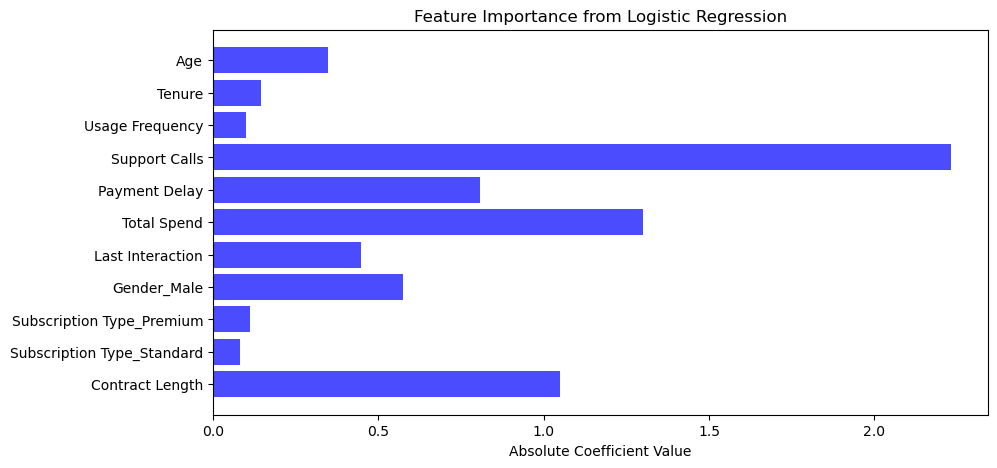

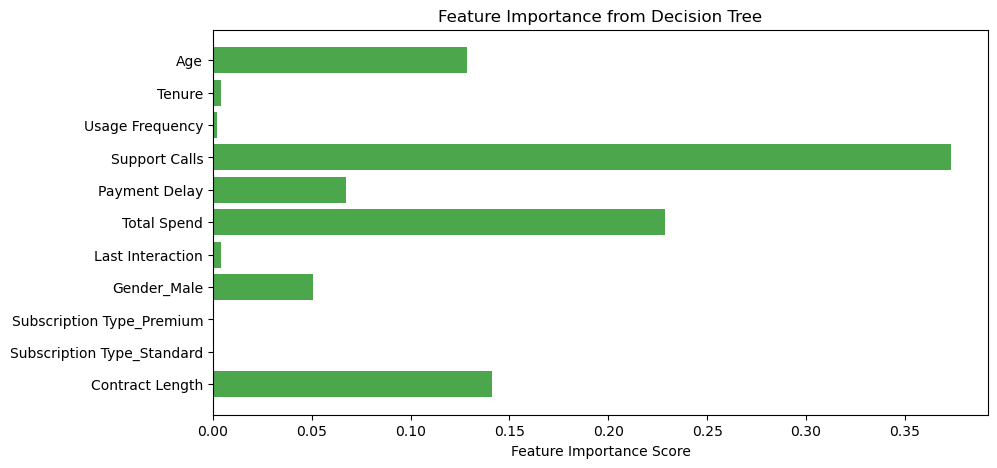

In [62]:
import matplotlib.pyplot as plt
log_reg_importance = np.abs(log_reg.coef_[0])
log_reg_features = X.columns

# Get feature importance from Decision Tree
tree_importance = tree.feature_importances_

# Plot Logistic Regression feature importance
plt.figure(figsize=(10, 5))
plt.barh(log_reg_features, log_reg_importance, color='blue', alpha=0.7)
plt.xlabel("Absolute Coefficient Value")
plt.title("Feature Importance from Logistic Regression")
plt.gca().invert_yaxis()
plt.show()

# Plot Decision Tree feature importance
plt.figure(figsize=(10, 5))
plt.barh(log_reg_features, tree_importance, color='green', alpha=0.7)
plt.xlabel("Feature Importance Score")
plt.title("Feature Importance from Decision Tree")
plt.gca().invert_yaxis()
plt.show()

The feature importance analysis aligns with the cohort analysis in some key aspects but also provides additional insights. Both Logistic Regression and the Decision Tree highlight Support Calls, Contract Length, and Total Spend as highly influential features in predicting churn. This aligns with the cohort analysis, which showed that customers tend to churn within the first two years—suggesting that contract length and spending behavior play a crucial role. However, the models also emphasize Payment Delay and Gender, which were not directly evident in the cohort analysis. The focus on Support Calls as the most significant factor indicates that customers who frequently contact support may be experiencing service issues, leading to churn. This suggests that, beyond tenure-based retention strategies, businesses should prioritize improving customer service and addressing payment-related concerns to reduce churn.